## Data

In [126]:
import os
import numpy as np

def num_to_categorical(num):
    categorical = [0.] * 10
    categorical[num] = 1.
    return categorical

def categorical_to_num(categorical):
    return list(categorical).index(1.)

def load_data(data_type='Training'):
    filepath_in = os.path.join('pset2', 'Pset2_{}_Data_Input.csv'.format(data_type))
    filepath_out = os.path.join('pset2', 'Pset2_{}_Data_Output.csv'.format(data_type))
    features = np.genfromtxt(filepath_in, delimiter=',')
    targets = np.genfromtxt(filepath_out)
    targets = targets.astype(int)
    targets[targets == 10] = 0
    if data_type == 'Training':
        targets = np.array([num_to_categorical(target) for target in targets])
    assert len(features) == len(targets)
    return features, targets

features, targets = load_data()
print("Features: {}, Targets: {}".format(features.shape, targets.shape))


Features: (3000, 784), Targets: (3000, 10)


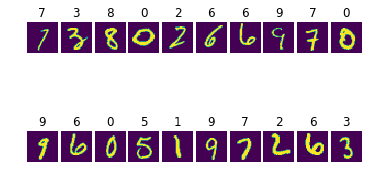

In [12]:
% matplotlib inline
from matplotlib import pyplot

fig, axes = pyplot.subplots(2, 10)
pyplot.subplots_adjust(hspace=0.001, wspace=0.1)

for i, ax in enumerate(axes.flatten()):
    ax.imshow(features[i].reshape([28, 28]).T)
    ax.set_title(categorical_to_num(targets[i]))
    ax.axis('off')


## 1. Weight update rule derivation

![backprop derivation](backprop-derivation.jpg "Update rule")

## 2. Train with SGD

In [157]:
import math

import numpy as np

def sigmoid(xs):
    return np.array([1 / (1 + math.exp(-x)) for x in xs])

class Net(object):
    def __init__(self, num_input, num_hidden, num_output, seed=0):
        np.random.seed(seed)
        # go from (input + 1) to (hidden). +1 to add the bias term
        self.w_xh = self.initialize(num_input + 1, num_hidden)
        # go from (hidden + 1) to (output). +1 to add the bias term
        self.w_hy = self.initialize(num_hidden + 1, num_output)

    def initialize(self, num_in, num_out):
        return np.random.rand(num_in, num_out) - 0.5

    def __call__(self, x):
        x = np.concatenate((x, [1.]))  # add 1-input for bias term
        net_h = np.dot(self.w_xh.T, x)  # dot product = sum(w_ij * x_i)
        h = sigmoid(net_h)
        h = np.concatenate((h, [1.]))  # add 1-input for bias term
        net_y = np.dot(self.w_hy.T, h)  # dot product = sum(w_ij * h_i)
        y = sigmoid(net_y)
        return y, net_y, h, net_h, x

    def predict(self, x):
        y, net_y, h, net_h, x = self(x)
        return np.argmax(y)  # winner-take-all: return the maximum value position

    def train_epochs(self, X, targets, num_epochs, learning_rate=0.01):
        for epoch in range(1, num_epochs + 1):
            yield list(self.train_epoch(X, targets, learning_rate=learning_rate))

    def train_epoch(self, X, targets, learning_rate):
        assert len(X) == len(targets)
        sampling = np.random.choice(len(X), len(X), replace=False)
        for sample in sampling:
            yield np.mean(self.train_sample(X[sample], targets[sample], learning_rate=learning_rate))

    def train_sampling(self, X, targets, num_samples, learning_rate=0.01):
        assert len(X) == len(targets)
        for sample_num in range(num_samples):
            sample = np.random.choice(len(X), replace=True)
            sample_error = np.mean(self.train_sample(X[sample], targets[sample], learning_rate=learning_rate))
            yield sample_error

    def train_sample(self, x, target, learning_rate):
        y, net_y, h, net_h, x = self(x)
        # compute loss
        error = np.power(target - y, 2)

        # update weights layer 2 (h -> y)
        # for i, j in itertools.product(range(self.w_xh.shape[0]), range(self.w_xh.shape[1])):
        #     self.w_xh[i, j] += - learning_rate * x[i] * h[j] * (1 - h[j]) * \
        #                      np.sum([self.w_hy[j, l] * (y[l] - target[l]) * y[l] * (1 - y[l]) for l in range(len(y))])
        # we can re-write the above element-wise update using matrices and the element-wise Hadamard product:
        error_derivative = (y - target) * y * (1 - y)
        d_w_xh = np.expand_dims(x, 1) * np.expand_dims(h[:self.w_xh.shape[1]] * (1 - h[:self.w_xh.shape[1]]), 1).T \
                 * np.sum(self.w_hy[:self.w_xh.shape[1]] * error_derivative, axis=1)

        # update weights layer 1 (x -> h). copying everything from (1)
        # for i, j in itertools.product(range(self.w_hy.shape[0]), range(self.w_hy.shape[1])):
        #     self.w_hy[i, j] += - learning_rate * h[i] * (y[j] - target[j]) * y[j] * (1 - y[j])
        # re-write with matrices:
        d_w_hy = np.expand_dims(h, 1) * np.expand_dims(error_derivative, 1).T
        self.update_weights(d_w_xh, d_w_hy, learning_rate=learning_rate)
        return error

    def update_weights(self, d_w_xh, d_w_hy, learning_rate):
        self.w_xh += -learning_rate * d_w_xh
        self.w_hy += -learning_rate * d_w_hy

    def accuracy(self, X, targets):
        predictions = np.array([net.predict(x) for x in X])
        correct = [prediction == target for prediction, target in zip(predictions, targets)]
        return sum(correct) / len(correct)


In [127]:
def normalize(x, mean=None, std=None):
    # pre-process: normalize to mean and stddev
    mean = mean if mean is not None else np.mean(x, axis=0)
    std = std if std is not None else np.std(x, axis=0)
    std[std == 0] = 1  # ignore zero-variance dimensions
    return (x - mean) / std, mean, std


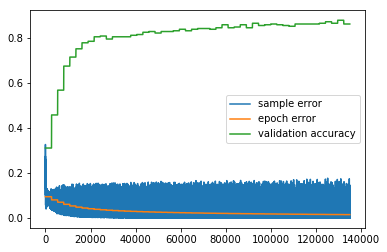

In [131]:
% matplotlib inline
from matplotlib import pyplot

# dev_features, features_mean, features_std = normalize(features)
dev_features = features

# split into training and validation to visualize generalization error
training_split = 0.9
training_samples = np.random.choice(len(dev_features), int(len(dev_features) * training_split), replace=False)
validation_samples = list(set(list(range(len(dev_features)))) - set(training_samples))
training_features, training_targets = dev_features[training_samples], targets[training_samples]
validation_features, validation_targets = dev_features[validation_samples], targets[validation_samples]
validation_targets = [categorical_to_num(t) for t in validation_targets]

# train with training samples, measure validation accuracy
net = Net(num_input=dev_features.shape[1], num_hidden=50, num_output=training_targets.shape[1])
train_epoch_errors, train_sample_errors, validation_accuracies = [], [], []
for sample_errors in net.train_epochs(training_features, training_targets, num_epochs=50):
    epoch_error = np.mean(sample_errors)
    train_epoch_errors += [epoch_error] * len(sample_errors)
    train_sample_errors += sample_errors
    validation_accuracy = net.accuracy(validation_features, validation_targets)
    validation_accuracies += [validation_accuracy] * len(sample_errors)

# plot
pyplot.plot(train_sample_errors)
pyplot.plot(train_epoch_errors)
pyplot.plot(validation_accuracies)
pyplot.legend(['sample error', 'epoch error', 'validation accuracy'])


## 3. Test on held-out data

In [131]:
test_features, test_targets = load_data(data_type='Test')
# test_features, _, __ = normalize(test_features, features_mean, features_std)
print("Accuracy: {:.2f}%".format(100 * net.accuracy(test_features, test_targets)))


Accuracy: 85.17%


## 4. Number of hidden nodes

20 only gave me ~80% test performance, I chose 50 using a power-law interpolation between 785 and 10.

## 5. Run from different seeds

Seed: 299


Seed: 904


Seed: 247


Seed: 785


Seed: 483


Seed: 599


Seed: 968


Seed: 87


Seed: 709


Seed: 993


Seed: 951


Seed: 891


Seed: 119


Seed: 776


Seed: 953


Seed: 32


Seed: 813


Seed: 153


Seed: 831


Seed: 861


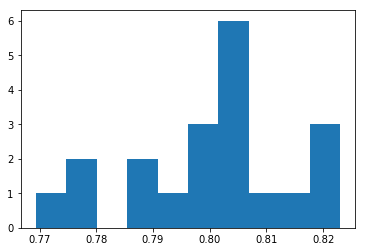

In [184]:
% matplotlib inline
from matplotlib import pyplot
import random

num_seeds = 20
test_accuracies = []
for _ in range(num_seeds):
    seed = random.randint(0, 999)
    print("Seed:", seed)
    net = Net(num_input=dev_features.shape[1], num_hidden=20, num_output=training_targets.shape[1], seed=seed)
    list(net.train_epochs(training_features, training_targets, num_epochs=25))
    test_acc = net.accuracy(test_features, test_targets)
    test_accuracies.append(test_acc)
pyplot.hist(test_accuracies)
pyplot.show()


Even from different initializations, we end up similarly high generalization performances.
So the local minima we end up in are likely very similar to the global minima.

## 6. Momentum

In [176]:
class MomentumNet(Net):
    def __init__(self, beta, *args, **kwargs):
        super(MomentumNet, self).__init__(*args, **kwargs)
        # no momentum in the beginning
        self.momentum_w_xh = 0
        self.momentum_w_hy = 0
        self.beta = beta

    def update_weights(self, d_w_xh, d_w_hy, learning_rate):
        # short-term memory with beta controlling the extent of the memory
        self.momentum_w_xh = self.beta * self.momentum_w_xh + d_w_xh
        self.momentum_w_hy = self.beta * self.momentum_w_hy + d_w_hy
        super(MomentumNet, self).update_weights(d_w_xh=self.momentum_w_xh, d_w_hy=self.momentum_w_hy, 
                                                learning_rate=learning_rate)


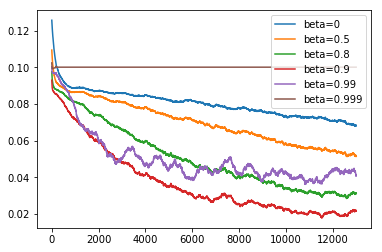

In [175]:
import itertools

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

errors = {}

# momentum - note that zero momentum is just standard SGD
for beta in [0, 0.5, 0.8, 0.9, 0.99, 0.999]:
    momentum_net = MomentumNet(num_input=dev_features.shape[1], num_hidden=20, num_output=training_targets.shape[1], 
                               beta=beta)
    errors['beta={}'.format(beta)] = list(itertools.chain(*momentum_net.train_epochs(training_features, training_targets, num_epochs=5)))

for errs in errors.values():
    pyplot.plot(moving_average(errs, n=500))
pyplot.legend(list(errors.keys()))


Momentum significantly speeds up training compared to standard SGD (beta=0).

Higher values seem to help more initially but after 5 epochs, a beta of 0.9 seems to work the best.
This is also the standard value used in practice.

These results suggest that the error surface is quite smooth without strong bumps since an accelerated traversal down the gradient improves training speed.
However, it is not a perfecttly smooth surface, otherwise higher beta values would always speed up training.

## 7. Overfitting with too many hidden nodes

In [178]:
net = Net(num_input=dev_features.shape[1], num_hidden=250, num_output=training_targets.shape[1])
list(net.train_epochs(training_features, training_targets, num_epochs=25))
test_acc = net.accuracy(test_features, test_targets)
print(test_acc)


0.852333333333


Even with a huge number of hidden nodes, it doesn't overfit.
This hints at the train and test distribution being similar, i.e. training and test samples are so similar that an overfit train model performs well on the test data.

Overfitting refers to when a model fits the training data so well that it doesn't generalize any more.
The famous example for this is noisy sampling from a polynomial - an overparametrized model would perfectly fit the noise but won't generalize to any new samples.

## 8. Stability <> Plasticity

Strategy: hold out one of the classes, train on the remaining 9 and show that the new class can still be learned afterwards BUT that this harms performance on the other 9 classes. 
Contrast this with training on all 10 classes from the beginning in 2./3.

In [182]:
num_targets = [categorical_to_num(target) for target in targets]
samples9 = [target in list(range(8)) for target in num_targets]
samples1 = [not sample for sample in samples9]
net = Net(num_input=dev_features.shape[1], num_hidden=25, num_output=training_targets.shape[1])
features9, targets9 = dev_features[samples9], targets[samples9]
features1, targets1 = dev_features[samples1], targets[samples1]
targets9_num, targets1_num = [categorical_to_num(target) for target in targets9], [categorical_to_num(target) for target in targets1]
# First, train on 9 digits
list(net.train_epochs(features9, targets9, num_epochs=25))
print("Performance on 9 numbers: {:.2f}%".format(100 * net.accuracy(features9, targets9_num)))
# Then, train on the remaining 1 digit
list(net.train_epochs(features1, targets1, num_epochs=25))
print("Performance on 1 number: {:.2f}%".format(100 * net.accuracy(features1, targets1_num)))
# Finally, show that performance on the first 9 digits has been harmed
print("Performance on 9 numbers after training on left-out number: {:.2f}%".format(100 * net.accuracy(features9, targets9_num)))

Performance on 9 numbers: 92.29%


Performance on 1 number: 95.33%
Performance on 9 numbers after training on left-out number: 4.17%


When we train on 9 numbers, we achieve good performance on that data.
However, when we then follow that up with training on the left-out digit, we achieve good performance on that digit too (plasticity) but we loose out on the performance on the original digits (missing stability).
Training on all 10 digits from the beginning gives much better performance but we are often not in a case where we can train on all the data right away.